In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import csv
import pandas as pd
import numpy as np

import datetime

In [2]:
%load_ext autoreload
%autoreload 1
%aimport hobo

In [3]:
hobo.strip_header_serial('data/motion_light data/ac206_2018-11-27.csv')
hobo.strip_header_serial('data/motion_light data/ac326_2018-11-27.csv')

'data/motion_light data/ac326_2018-11-27_fixed.csv'

In [4]:
ac206 = hobo.process_data('data/motion_light data/ac206_2018-11-27_fixed.csv')

In [5]:
ac206[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,date
2018-10-08 17:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00
2018-10-08 17:57:21-04:00,2,NaN,NaN,NaN,NaN,Logged,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00
2018-10-08 17:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00


In [6]:
occupancy = hobo.convert_to_length(ac206, 'Occupancy')

In [7]:
occupancy[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,date,delta
2018-10-08 17:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,NaT
2018-10-08 17:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,00:00:02
2018-10-08 17:59:33-04:00,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,00:02:11


In [8]:
occ_by_day = hobo.agg_week(occupancy, 'Occupancy')

In [9]:
occ_by_day

dayofweek
0   1 days 19:45:29
1   1 days 03:37:03
2   0 days 18:49:22
3   1 days 06:40:09
4   0 days 11:00:04
5   0 days 13:45:00
6   0 days 12:04:20
Name: delta, dtype: timedelta64[ns]

Text(0.5,1,'Avg hours of occupancy in AC206 by day of week')

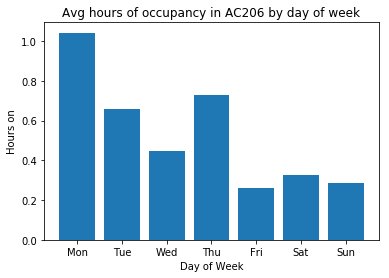

In [10]:
fig = plt.figure()
plt.bar(
    occ_by_day.index,
    occ_by_day / (6*7*np.timedelta64(1, 'h')),
)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Hours on')
plt.title('Avg hours of occupancy in AC206 by day of week')

For a more accurate average, we could normalize by:
- total number of weeks in the dataset
- total number of days in the dataset for each day of the week
- total number of hours in the dataset
- total number of hours in the dataset for each day of the week

### Total number of days

In [11]:
total_time = (ac206[-1:].index - ac206[:1].index)[0]
total_time

Timedelta('50 days 06:47:41')

In [12]:
total_hours = total_time / pd.Timedelta(1, 'h')
total_hours

1206.7947222222222

In [13]:
total_days = total_time / pd.Timedelta(1, 'd')
total_days

50.283113425925926

In [14]:
occ_by_day  # total sums

dayofweek
0   1 days 19:45:29
1   1 days 03:37:03
2   0 days 18:49:22
3   1 days 06:40:09
4   0 days 11:00:04
5   0 days 13:45:00
6   0 days 12:04:20
Name: delta, dtype: timedelta64[ns]

In [15]:
occ_by_day / (6*7*np.timedelta64(1, 'h'))  # previous estimate

dayofweek
0    1.041858
1    0.657560
2    0.448161
3    0.730218
4    0.261931
5    0.327381
6    0.287434
Name: delta, dtype: float64

In [16]:
occ_by_day / ((total_days / 7) * np.timedelta64(1, 'h'))

dayofweek
0    6.251151
1    3.945357
2    2.688968
3    4.381310
4    1.571587
5    1.964286
6    1.724603
Name: delta, dtype: float64

28 hours per day? I think we'll have to calculate total time measured per day of week.

In [17]:
ac206.groupby('dayofweek').agg(['min','max'])

#       Light      Occupancy                           date  \
            min   max   min  max       min  max                       min   
dayofweek                                                                   
0             1  4104   0.0  1.0       0.0  1.0 2018-10-08 00:00:00-04:00   
1           116  4222   0.0  1.0       0.0  1.0 2018-10-09 00:00:00-04:00   
2           327  4011   0.0  1.0       0.0  1.0 2018-10-10 00:00:00-04:00   
3           574  4015   0.0  1.0       0.0  1.0 2018-10-11 00:00:00-04:00   
4           757  4019   0.0  1.0       0.0  1.0 2018-10-12 00:00:00-04:00   
5          1043  3537   0.0  1.0       0.0  1.0 2018-10-13 00:00:00-04:00   
6          1323  4021   0.0  1.0       0.0  1.0 2018-10-14 00:00:00-04:00   

                                     
                                max  
dayofweek                            
0         2018-11-26 00:00:00-05:00  
1         2018-11-27 00:00:00-05:00  
2         2018-11-21 00:00:00-05:00  
3         2018-11-22 00:00:00-05:00  
4         2018-11-23 00:00:00-05:00  
5         2018-11-10 00:00:00-05:00  
6         2018-11-25 00:00:00-05:00

In [18]:
ac206[-1:].index

DatetimeIndex(['2018-11-27 23:45:01-05:00'], dtype='datetime64[ns, US/Eastern]', freq=None)

In [19]:
ac206[:1].index

DatetimeIndex(['2018-10-08 17:57:20-04:00'], dtype='datetime64[ns, US/Eastern]', freq=None)

In [20]:
days = pd.DataFrame(pd.date_range(start='2018-10-08', end='2018-11-27', freq='D', tz='US/Eastern'), columns=['date'])

In [21]:
days['dayofweek'] = days['date'].dt.dayofweek

In [22]:
day_totals = days.groupby('dayofweek')['date'].agg('count')  # total number of each day of the week
day_totals

dayofweek
0    8
1    8
2    7
3    7
4    7
5    7
6    7
Name: date, dtype: int64

In [23]:
occ_by_day / day_totals

dayofweek
0   05:28:11.125000
1   03:27:07.875000
2   02:41:20.285714
3   04:22:52.714285
4   01:34:17.714285
5   01:57:51.428571
6   01:43:28.571428
dtype: timedelta64[ns]

21.25269841269778


(0, 8)

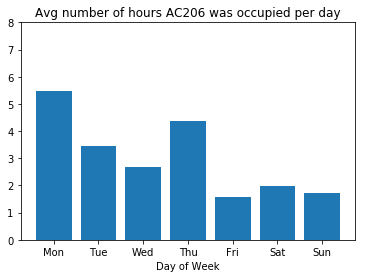

In [33]:
fig = hobo.plot_by_day(ac206, 'Occupancy')
plt.title('Avg number of hours AC206 was occupied per day')
plt.ylim((0,8))

25.255231481480834
20.094120370369723


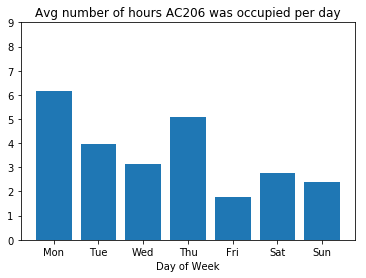

In [39]:
fig = hobo.plot_by_day(ac206[ac206.index <= pd.to_datetime('2018-11-18').tz_localize('US/Eastern')], 'Occupancy')
plt.title('Avg number of hours AC206 was occupied per day')
plt.ylim((0,9))
fig.savefig('ac206.png')

In [26]:
ac326 = hobo.process_data('data/motion_light data/ac326_2018-11-27_fixed.csv')

30.739694444443888
28.657037037036666


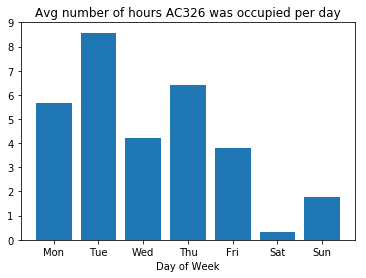

In [38]:
fig = hobo.plot_by_day(ac326[ac326.index <= pd.to_datetime('2018-11-18').tz_localize('US/Eastern')], 'Occupancy')
plt.title('Avg number of hours AC326 was occupied per day')
plt.ylim((0,9))
fig.savefig('ac326.png')

Text(0.5,1,'Avg number of hours AC326 lights were on per day')

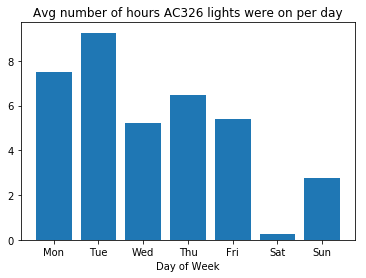

In [62]:
fig = hobo.plot_by_day(ac326[ac326.index <= pd.to_datetime('2018-11-18').tz_localize('US/Eastern')], 'Light')
plt.title('Avg number of hours AC326 lights were on per day')

Text(0.5,1,'Avg number of hours AC206 lights were on per day')

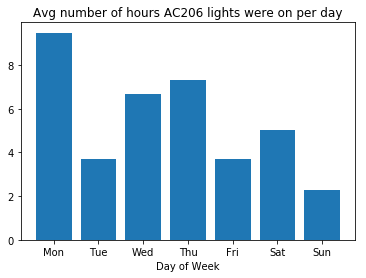

In [63]:
fig = hobo.plot_by_day(ac206[ac206.index <= pd.to_datetime('2018-11-18').tz_localize('US/Eastern')], 'Light')
plt.title('Avg number of hours AC206 lights were on per day')

## Plot ALL the data
(to make sure everything makes sense)

### Every day

In [31]:
occupancy[:3]

,#,Light,Occupancy,Started,Internal Calibration,Button Up,Host Connected,Stopped,End Of File,dayofweek,date,delta
2018-10-08 17:57:20-04:00,1,1.0,0.0,Logged,Logged,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,NaT
2018-10-08 17:57:22-04:00,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,00:00:02
2018-10-08 17:59:33-04:00,8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2018-10-08 00:00:00-04:00,00:02:11


In [32]:
occupancy.groupby('date')['delta'].agg('sum')

date
2018-10-08 00:00:00-04:00   0 days 05:58:07
2018-10-09 00:00:00-04:00   1 days 00:04:05
2018-10-10 00:00:00-04:00   0 days 23:48:24
2018-10-11 00:00:00-04:00   1 days 00:07:38
2018-10-12 00:00:00-04:00   1 days 00:03:16
2018-10-13 00:00:00-04:00   0 days 23:48:10
2018-10-14 00:00:00-04:00   0 days 19:46:44
2018-10-15 00:00:00-04:00   1 days 03:24:32
2018-10-16 00:00:00-04:00   0 days 20:06:49
2018-10-17 00:00:00-04:00   1 days 00:49:08
2018-10-18 00:00:00-04:00   1 days 02:21:22
2018-10-19 00:00:00-04:00   0 days 22:22:57
2018-10-20 00:00:00-04:00   1 days 00:31:28
2018-10-21 00:00:00-04:00   1 days 00:24:46
2018-10-22 00:00:00-04:00   1 days 02:11:09
2018-10-23 00:00:00-04:00   0 days 23:28:02
2018-10-24 00:00:00-04:00   1 days 00:01:43
2018-10-25 00:00:00-04:00   0 days 22:41:42
2018-10-26 00:00:00-04:00   1 days 02:02:29
2018-10-27 00:00:00-04:00   0 days 20:17:23
2018-10-28 00:00:00-04:00   1 days 00:32:34
2018-10-29 00:00:00-04:00   1 days 02:47:04
2018-10-30 00:00:00-04:00  

### All points, per week

In [33]:
ac206.index >= pd.to_datetime('2018-10-10').tz_localize('US/Eastern')

array([False, False, False, ...,  True,  True,  True])

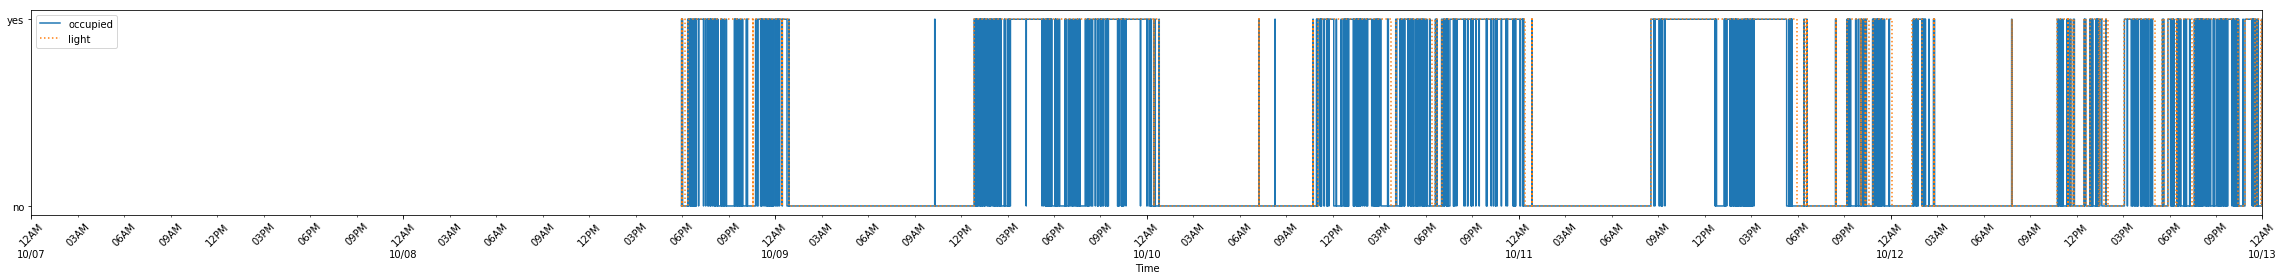

In [52]:
import pytz

def plot_range(d, tstart, tend):
    fig = plt.figure()
    data = d[(d.index >= tstart) & (d.index < tend)]
    l = ~data['Light'].isnull()
    o = ~data['Occupancy'].isnull()
    plt.plot(
        data.index[o],
        data[o]['Occupancy'],
        drawstyle='steps-post',
        label='occupied'
    )
    plt.plot(
        data.index[l],
        data[l]['Light'],
        drawstyle='steps-post',  # https://stackoverflow.com/questions/35579480/how-to-plot-square-function-with-matplotlib#35579598
        linestyle=':',
        label='light'
    )
    ax = plt.gca()
#     plt.title('Occupancy sensor')
    plt.yticks([0,1],['no','yes'])
    # plt.ylabel('Value')
    plt.xlabel('Time')
    ax.set_xticks(pd.date_range(start=tstart, end=tend, freq='D'))
#     ax.set_xticks(pd.date_range(start=tstart, end=tend, freq='h'), minor=True)
#     ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d', tz=pytz.timezone('US/Eastern')))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%I%p', tz=pytz.timezone('US/Eastern')))
#     plt.xticks(rotation=45)
    ax.xaxis.set_tick_params(which='major', pad=30)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)  # https://stackoverflow.com/questions/41390487/rotate-minor-ticks-in-matplotlib
    plt.legend()
#     fig.autofmt_xdate()  # https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib#23009503
    fig.patch.set_facecolor('white')  # needed for dark theme https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color
    plt.xlim((tstart, tend))
    plt.margins(x=0)
    plt.tight_layout()
    return fig

fig = plot_range(ac206, pd.to_datetime('2018-10-07').tz_localize('US/Eastern'), pd.to_datetime('2018-10-13').tz_localize('US/Eastern'))
fig.set_size_inches(36,4)

In [ ]:
fig.savefig('neat.pdf')

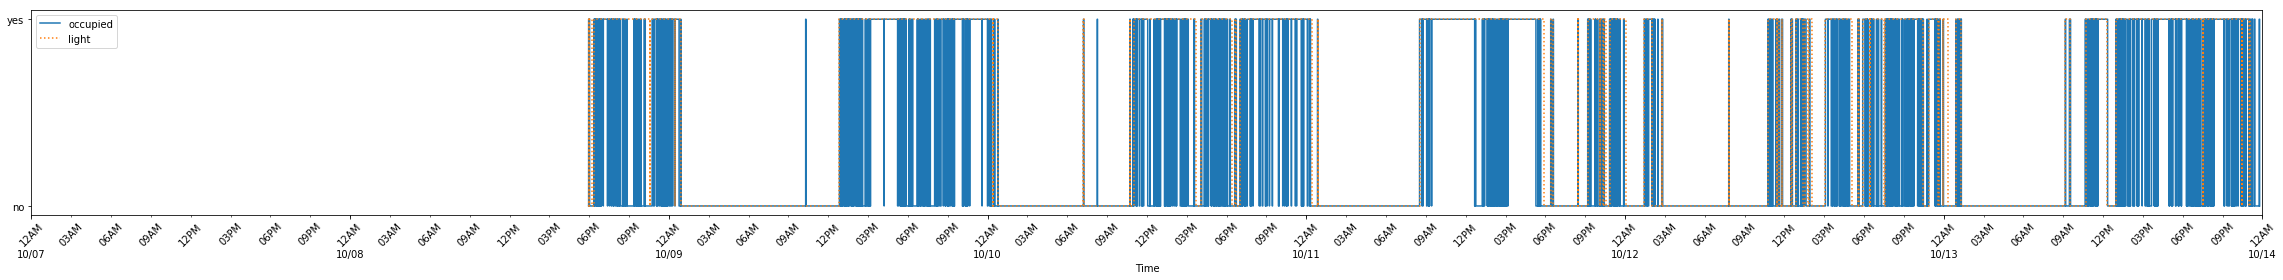

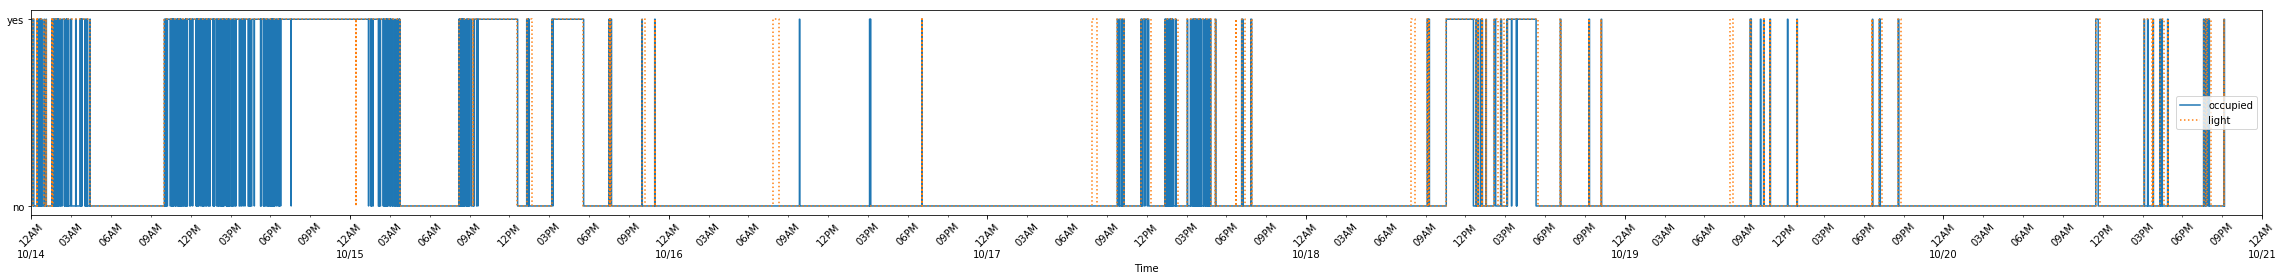

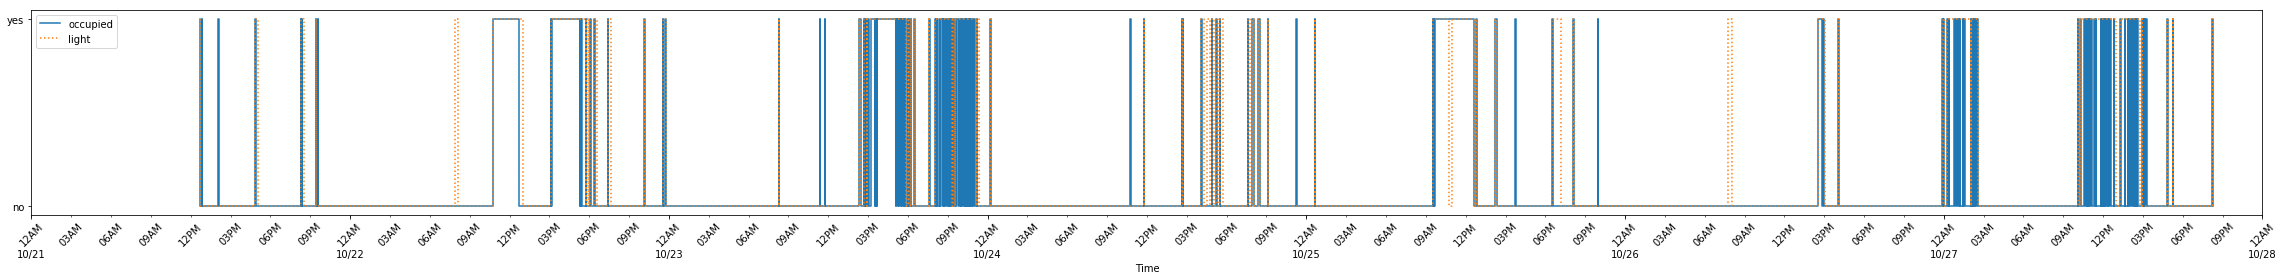

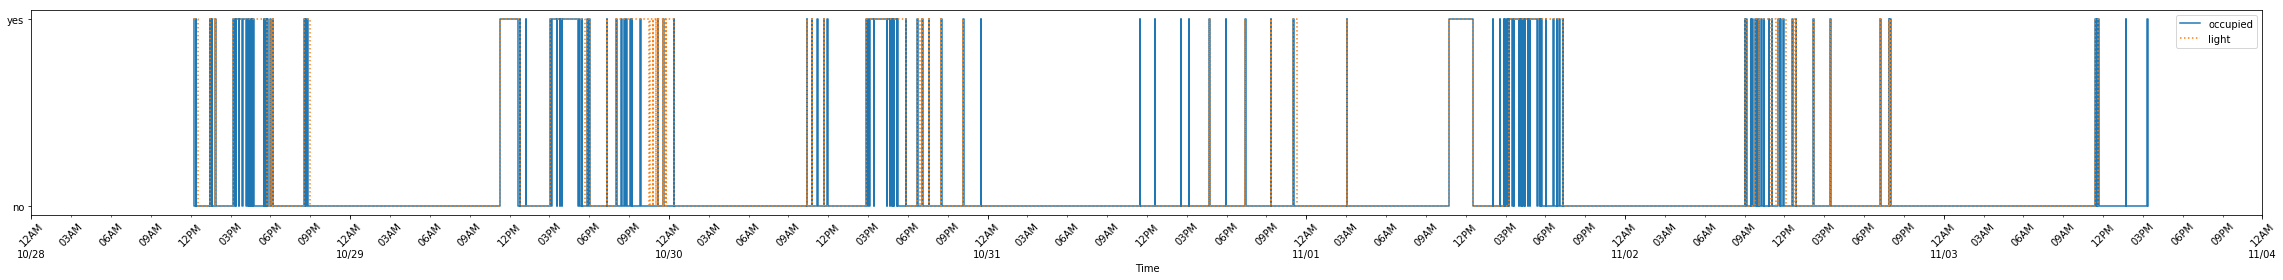

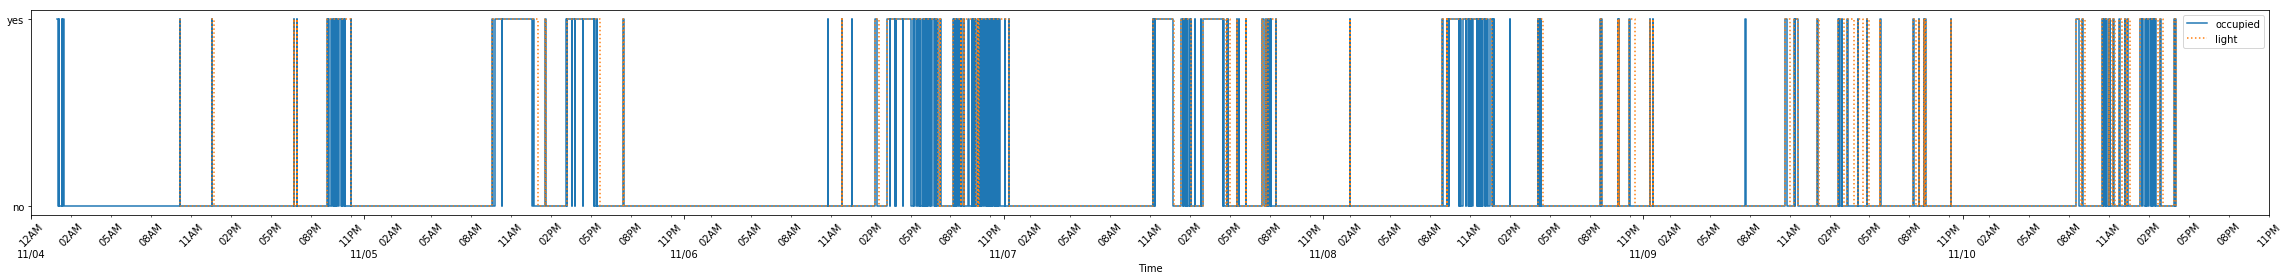

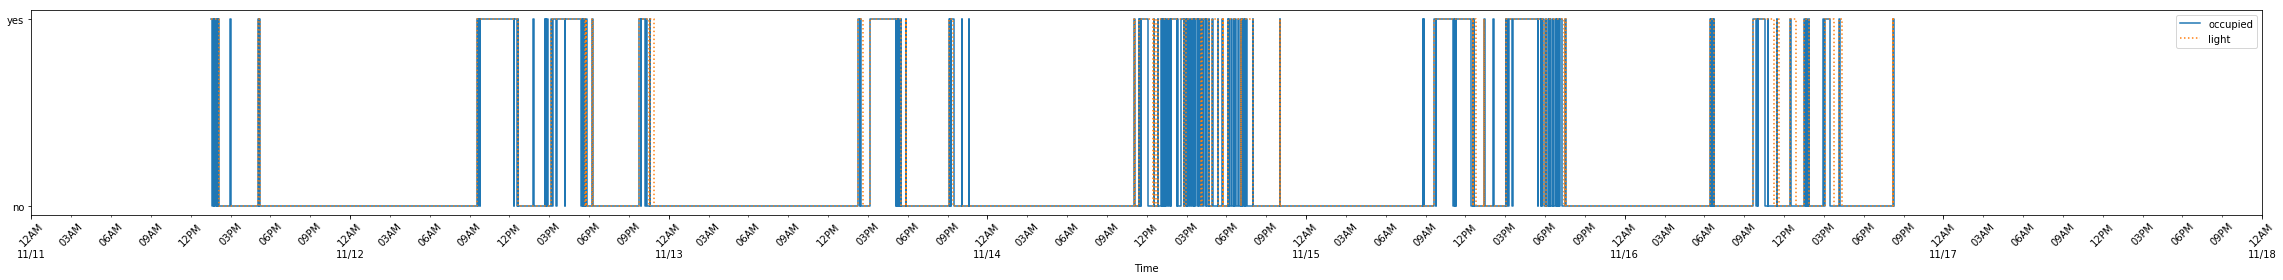

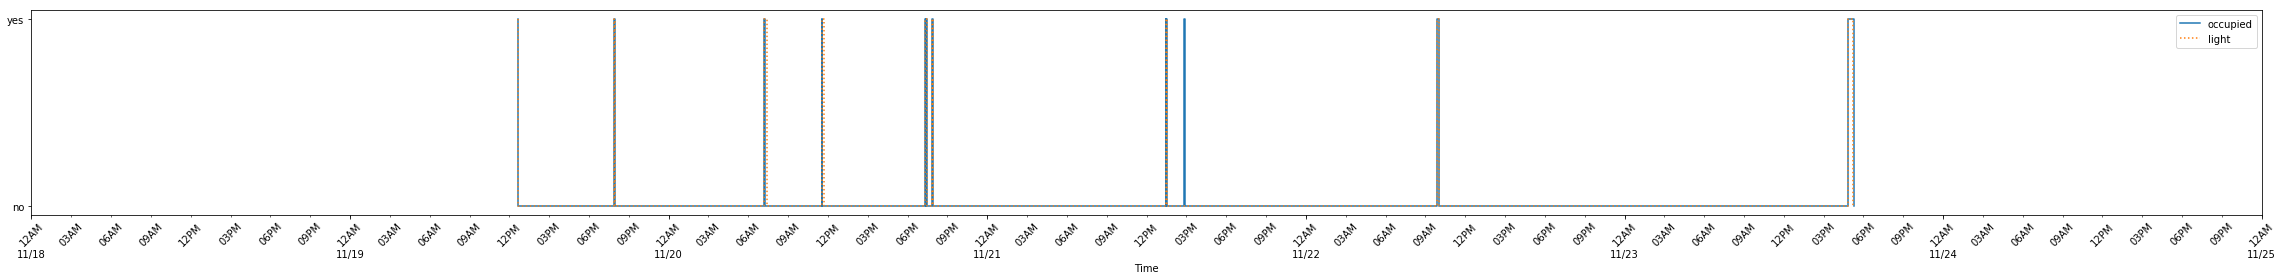

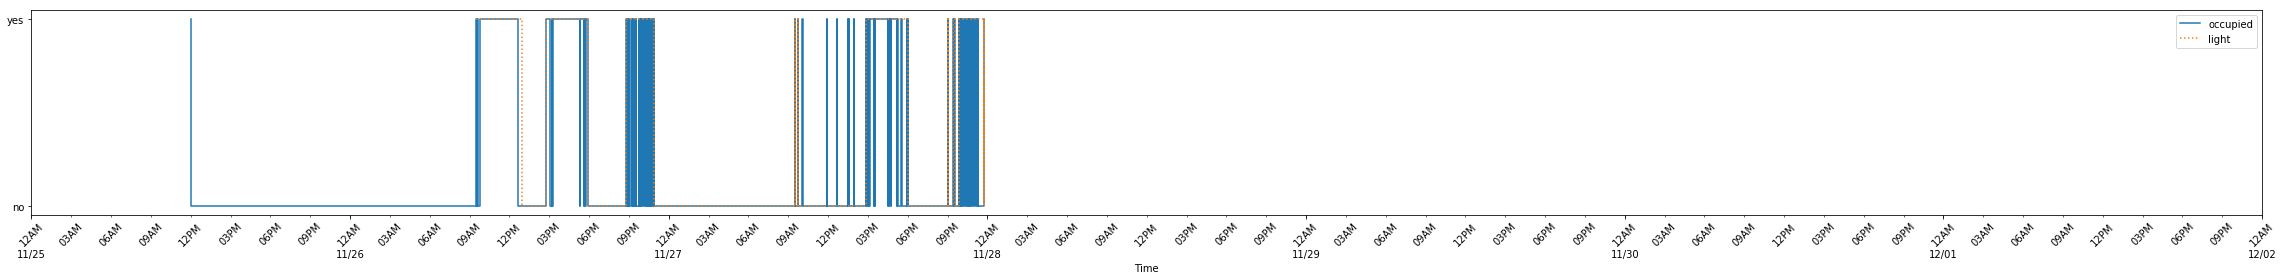

In [54]:
weeks = pd.date_range(start='2018-10-01', end='2018-11-27', freq='w', tz='US/Eastern')
for i, sunday in enumerate(weeks):
    eow = sunday + pd.to_timedelta(1, 'w')  # end of the week
    fig = plot_range(ac206, sunday, eow)
    fig.set_size_inches(36,4)
    fig.savefig('ac206_'+str(sunday.month)+'-'+str(sunday.day)+'_'+str(eow.month)+'-'+str(eow.day)+'.pdf')

In [ ]:
hobo.strip_header_serial('data/raw/motion-light data/ac326_2018-11-27.csv')

In [ ]:
ac326 = hobo.process_data('data/raw/motion-light data/ac326_2018-11-27_fixed.csv')

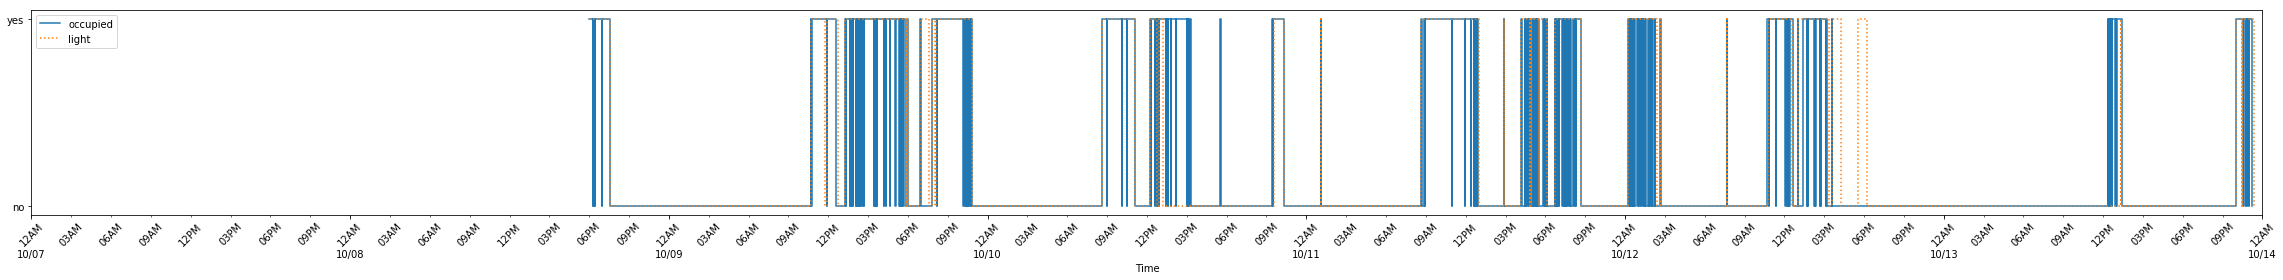

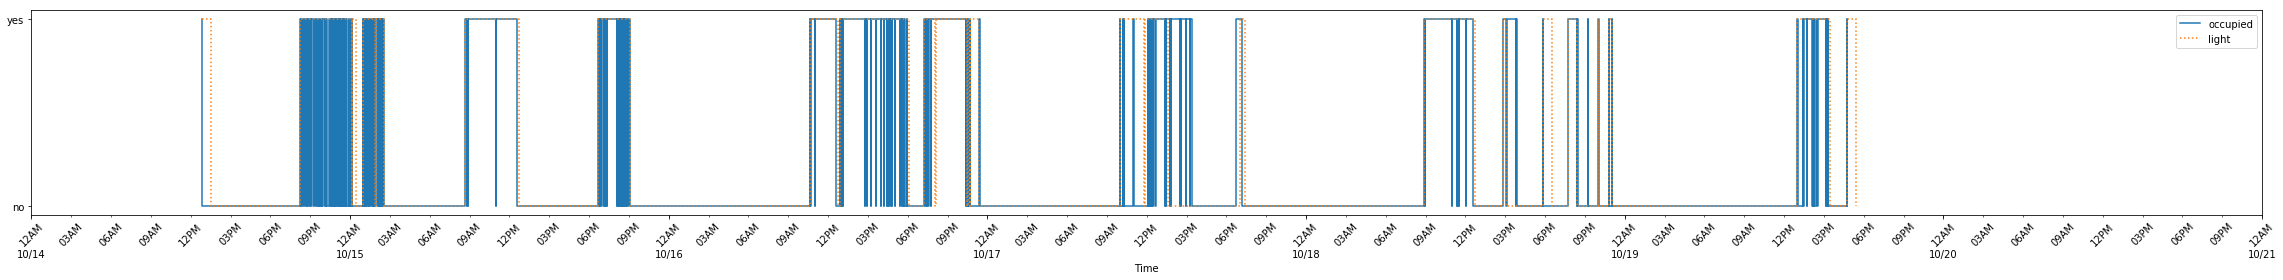

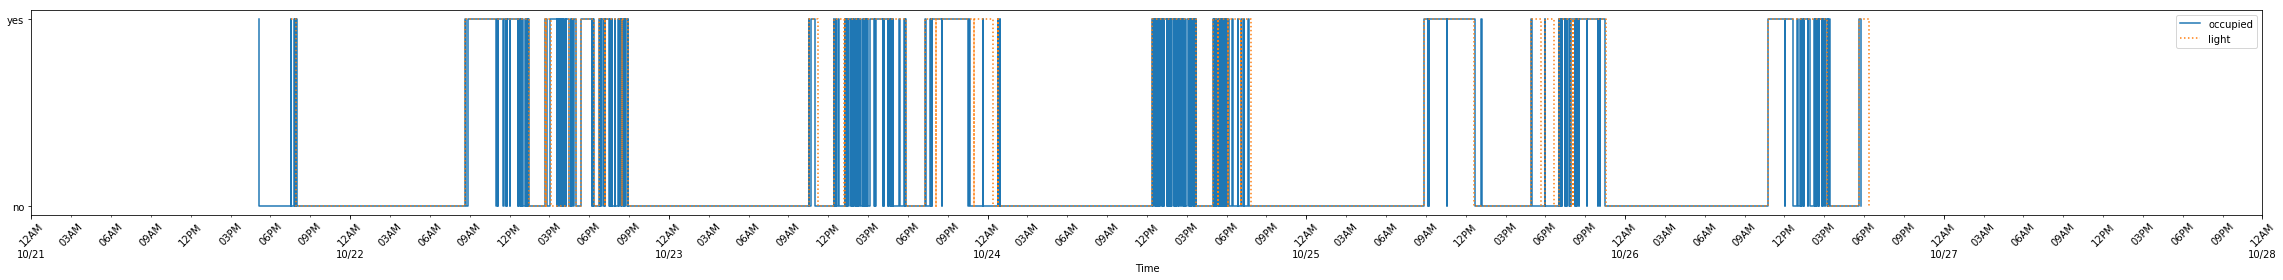

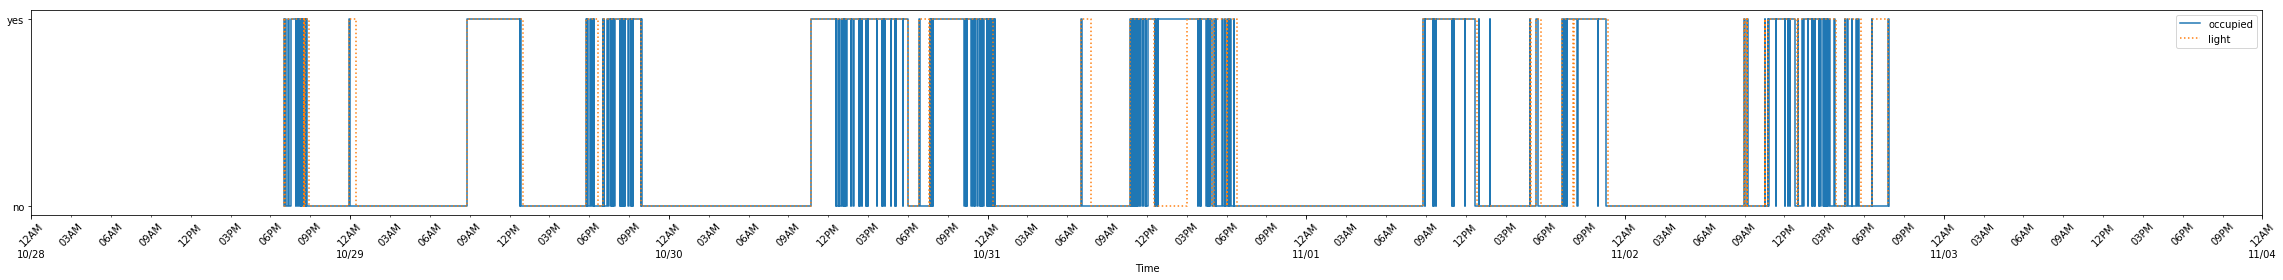

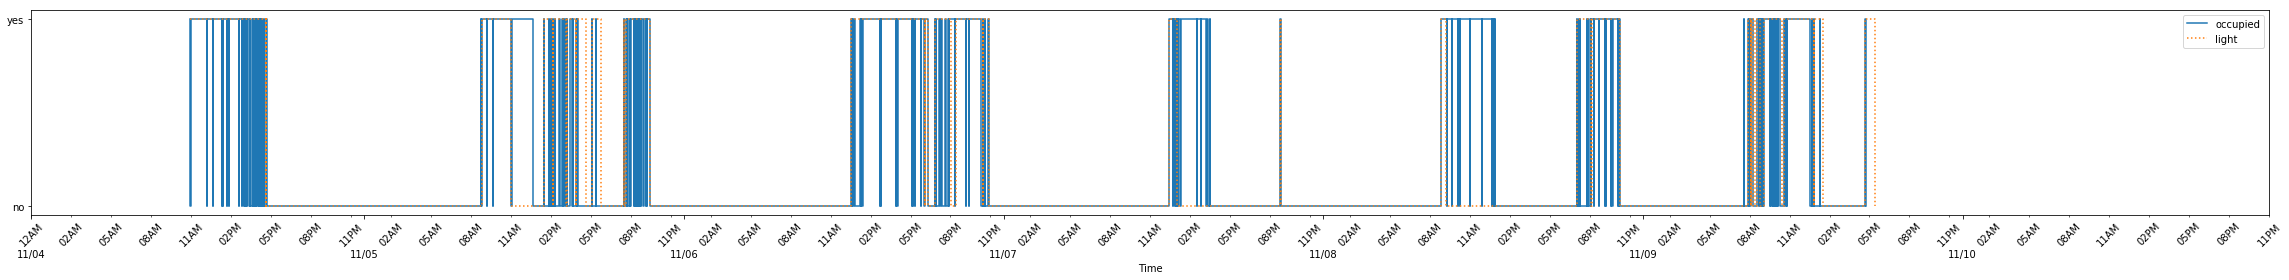

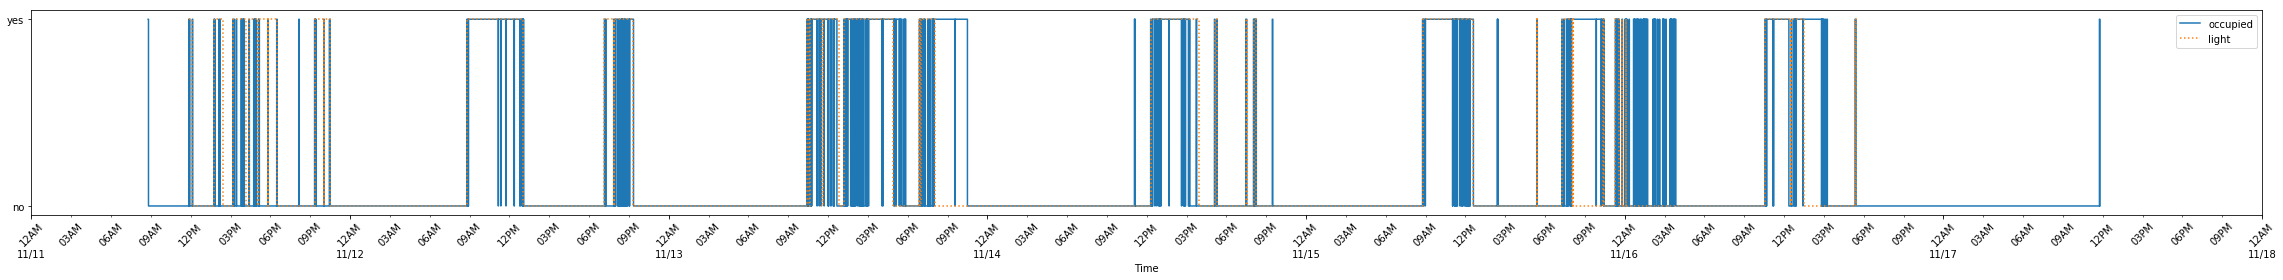

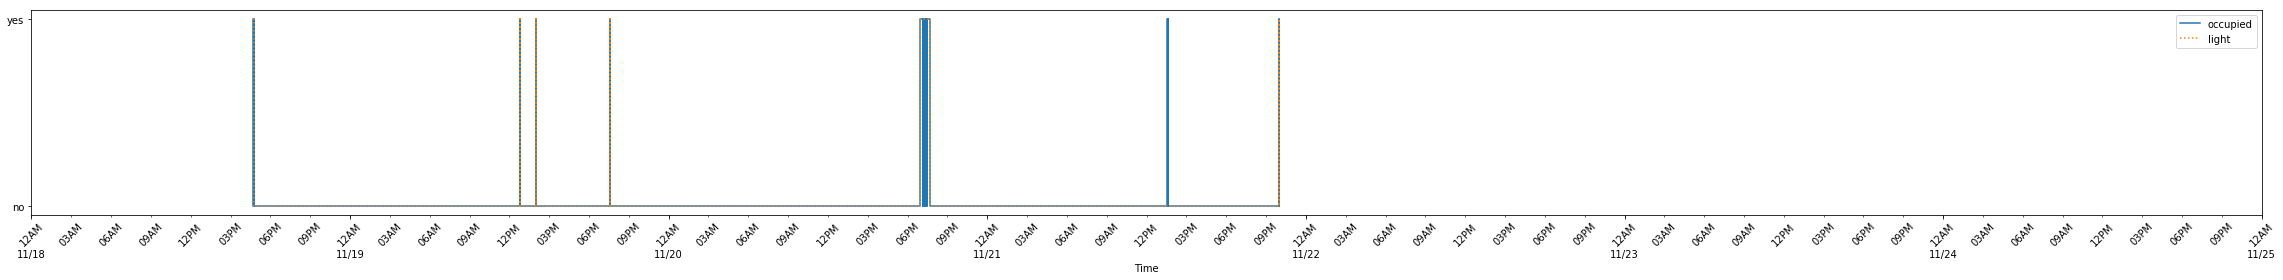

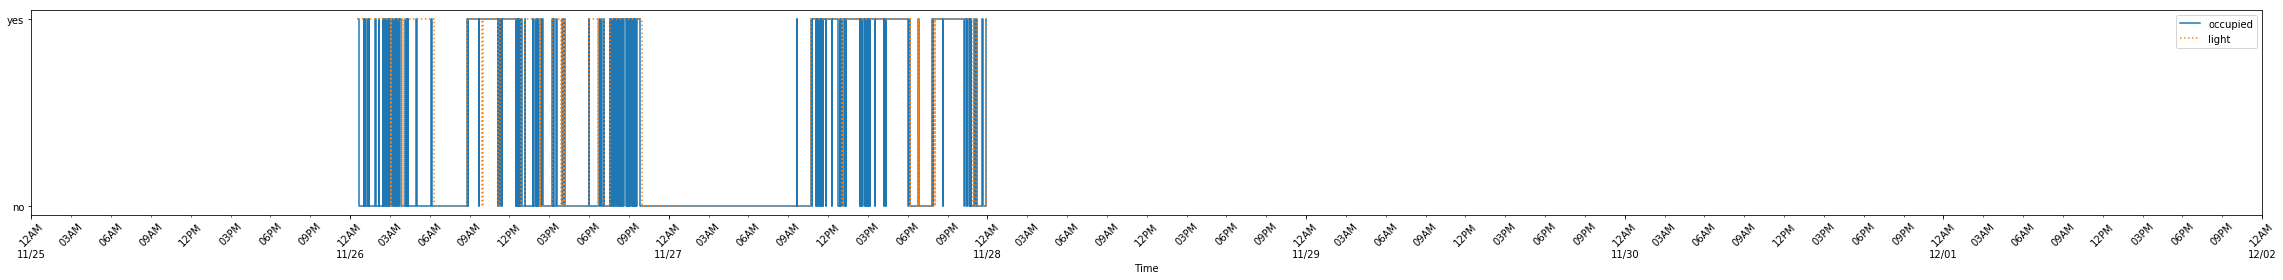

In [55]:
weeks = pd.date_range(start='2018-10-01', end='2018-11-27', freq='w', tz='US/Eastern')
for i, sunday in enumerate(weeks):
    eow = sunday + pd.to_timedelta(1, 'w')  # end of the week
    fig = plot_range(ac326, sunday, eow)
    fig.set_size_inches(36,4)
    fig.savefig('ac326_'+str(sunday.month)+'-'+str(sunday.day)+'_'+str(eow.month)+'-'+str(eow.day)+'.pdf')